In [6]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm_notebook

In [9]:
theta_true = np.random.randn(3,1)
epsilon_var = 1.0
def generate_data(sample_size = 20, scale0 = 1, scale1 = 1e10):
    x0 = np.random.rand(sample_size, 1)*scale0
    x1 = np.random.rand(sample_size, 1)*scale1
    
    X = np.concatenate([x0, x1], axis=1)
    X_extended = np.hstack([np.ones((X.shape[0],1)), X])
    
    y = np.dot(X_extended, theta_true) + np.random.randn(X_extended.shape[0],1)*np.sqrt(epsilon_var)
    return X,y

In [10]:
theta_true

array([[0.66822908],
       [1.62833583],
       [0.19101498]])

In [11]:
S0 = 1
S1 = 1

In [13]:
X,y = generate_data(sample_size=1000, scale0=S0, scale1=S1)

In [14]:
X.shape, y.shape

((1000, 2), (1000, 1))

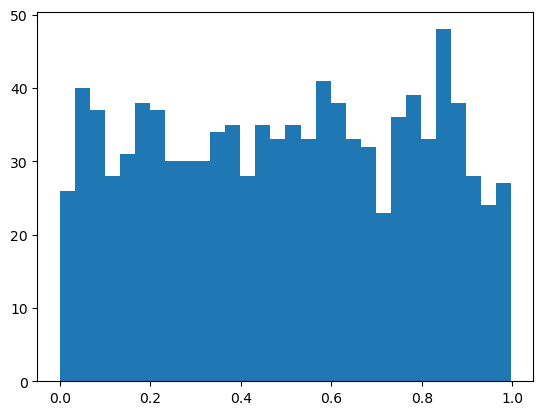

In [15]:
plt.hist(X[:,0], bins=30);

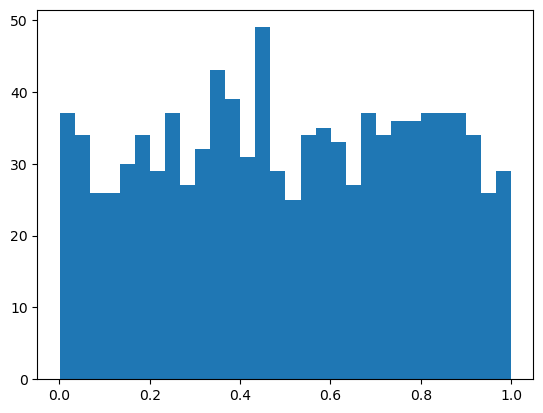

In [16]:
plt.hist(X[:,1], bins=30);

In [17]:
X_test,y_test = generate_data(sample_size=1000, scale0=S0, scale1=S1)

In [18]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:
print('         true theta is ', theta_true.T)
print('trained model theta is ', np.concatenate([model.intercept_[:, np.newaxis], model.coef_], axis=1))

         true theta is  [[0.66822908 1.62833583 0.19101498]]
trained model theta is  [[0.59920839 1.72307074 0.19842287]]


In [24]:
mae = mean_absolute_error(y, model.predict(X))
mae

0.7645088128148878

Text(0, 0.5, '$y$')

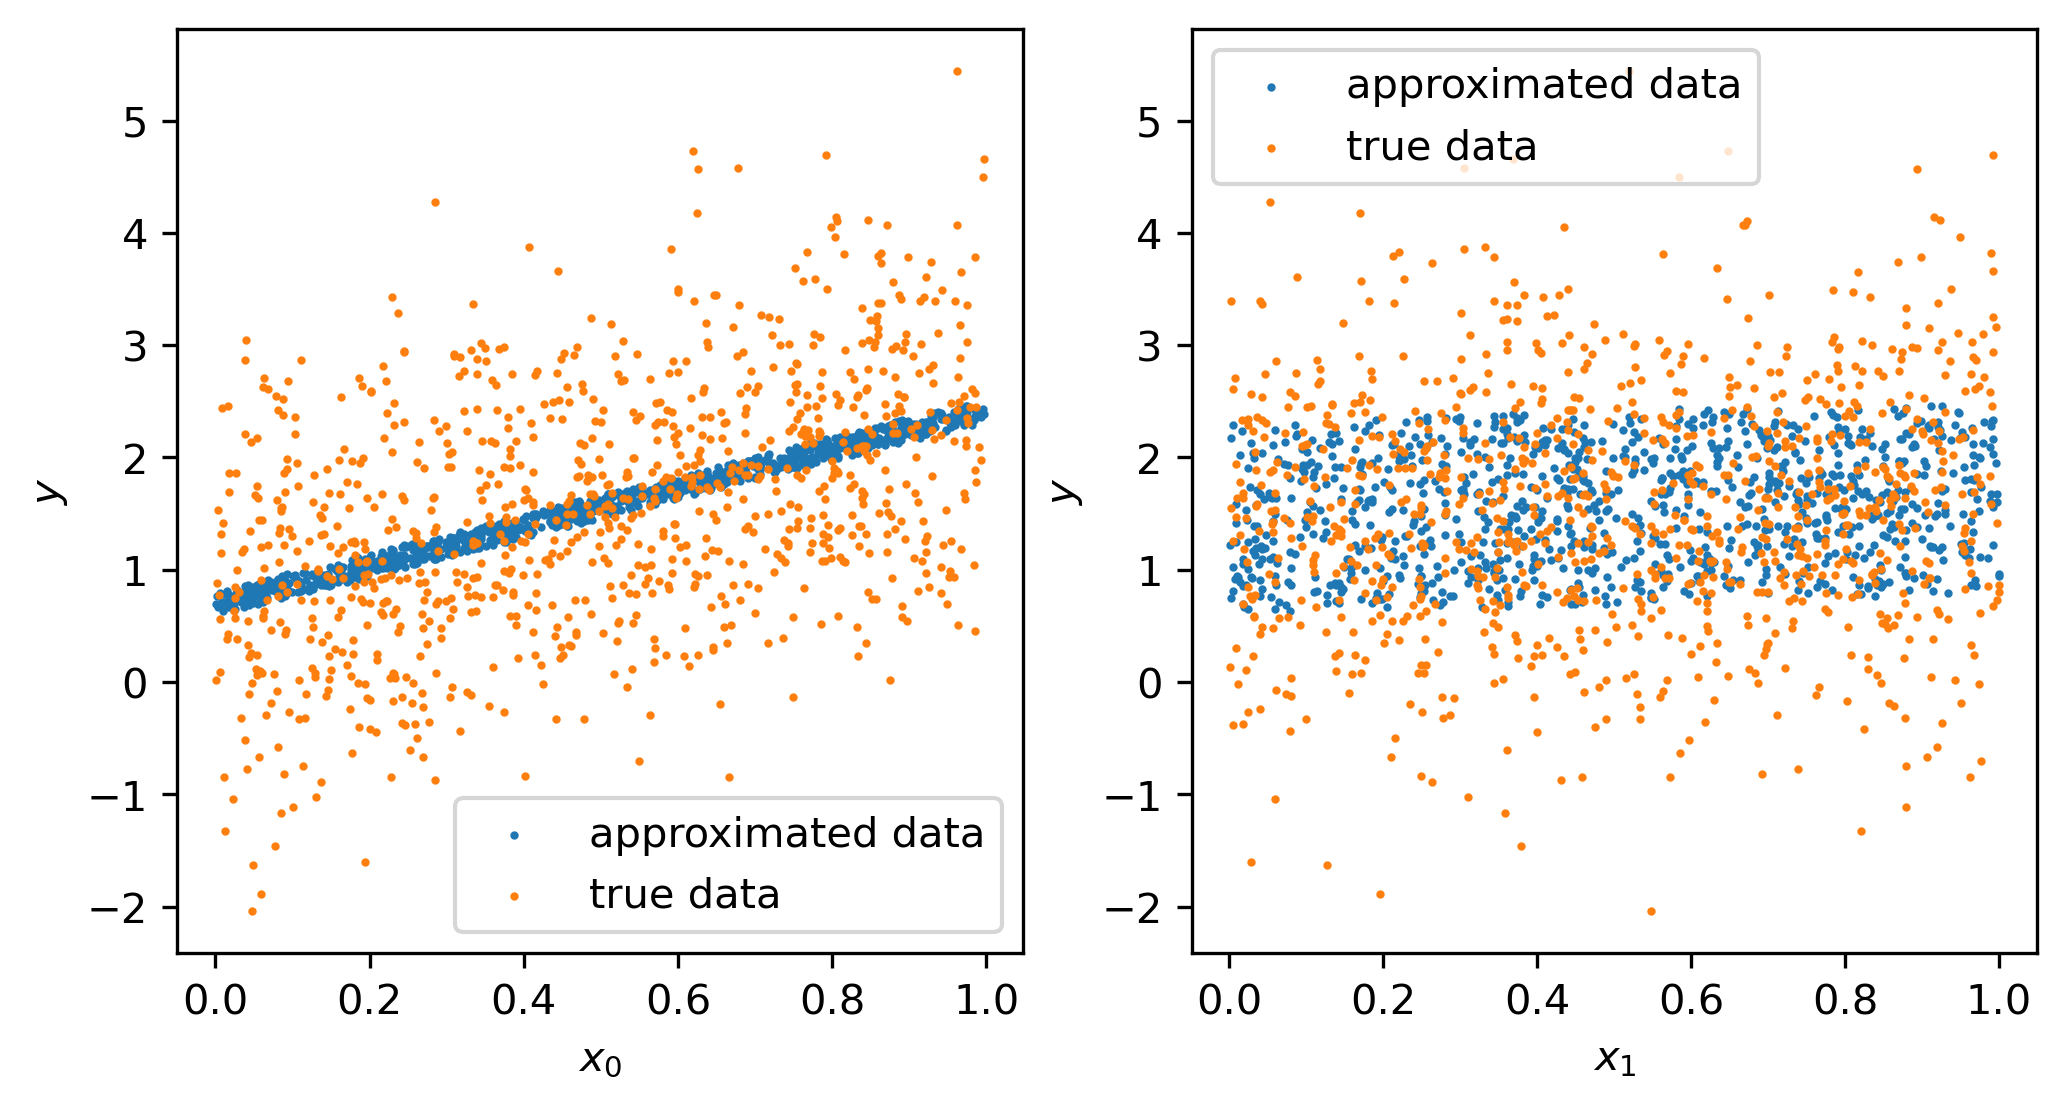

In [21]:
f = plt.figure(figsize=(8,4), dpi=300)
p1 = plt.subplot(1,2,1)
plt.scatter(X[:,0], model.predict(X), s=1, label = "approximated data")
plt.scatter(X[:,0], y, s=1, label = "true data")
plt.legend()
plt.xlabel('$x_0$')
plt.ylabel('$y$')

p1 = plt.subplot(1,2,2)
plt.scatter(X[:,1], model.predict(X), s=1, label = "approximated data")
plt.scatter(X[:,1], y, s=1, label = "true data")
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$y$')

## Посмотрим, что происходит на тестовой выборке

In [22]:
y_pred_test = model.predict(X_test)

In [23]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_test

0.8007594427716647

# ОБСУЖДЕНИЕ

### - Модель МО в задаче регрессии **чересчур уверенна** (дисперсия целевой переменной снижена по сравнению с обучающей выборкой)
### - Качество на обучающей выборке **отличается** от качества на новых данных, порождаемых из того же распределения (на тестовой выборке)

### Получим ли одно и то же качество, если будем обучаться на разных тренировочных выборках?

In [25]:
mae_train_array = []
mae_test_array = []
for idx in tqdm_notebook(range(10000), total=10000):
    X_train,y_train = generate_data(sample_size=1000, scale0=S0, scale1=S1)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_train_array.append(mae_train)
    
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_test_array.append(mae_test)

/tmp/ipykernel_3640/1396124767.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(10000), total=10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0, 'MAE values')

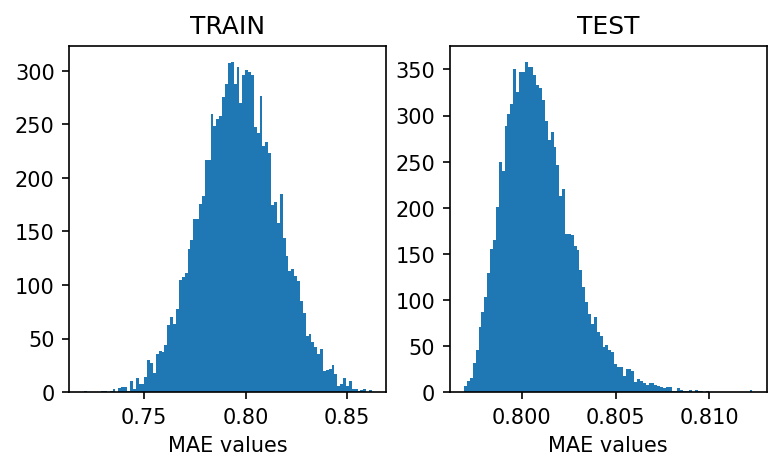

In [29]:
f = plt.figure(figsize=(6,3), dpi=150)
p1 = plt.subplot(1,2,1)
plt.hist(mae_train_array, bins=100)
plt.title('TRAIN')
plt.xlabel('MAE values')

p1 = plt.subplot(1,2,2)
plt.hist(mae_test_array, bins=100)
plt.title('TEST')
plt.xlabel('MAE values')

Text(0.5, 0, 'MAE values')

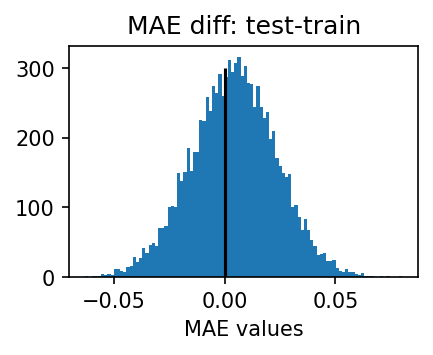

In [31]:
f = plt.figure(figsize=(3,2), dpi=150)
plt.hist(np.array(mae_test_array)-np.array(mae_train_array), bins=100, label='diff')
plt.vlines(0.0, 0.0, 300, "black")
plt.title("MAE diff: test-train")
plt.xlabel('MAE values')

# ОБСУЖДЕНИЕ

### даже в идеализированном случае:

- Мера качества на тестовой выборке чаще всего хуже меры качества на тренировочной;
- Мера качества на тестовой выборке МОЖЕТ БЫТЬ лучше меры качества на тренировочной;
- Мера качества - не одна фиксированная величина. Это случайная величина, у которой есть распределение, мат.ожидание, неопределенность;
- Оценка меры качества на тренировочной выборке НЕ ДАЕТ достоверного представления о том, какова она будет на этапе применения модели. Нужно оценивать меру качества на отложенной выборке.
- Одна реализация оценки меры качества НЕ ДАЕТ достоверного представления о том, какова она будет на этапе применения модели. Нужно оценивать ее мат.ожидание.

### Что будет, если масштабы признаков различаются?

In [32]:
mae_test_vars = []
y_test_vars = []
for ln_k in tqdm_notebook(np.linspace(0, 15, 30)):
    S1 = np.exp(ln_k)
    
    mae_test_array = []
    y_test_preds = []
    for idx in range(1000):
        X_train,y_train = generate_data(sample_size=1000, scale0=S0, scale1=S1)
        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred_test = model.predict(X_test)
        y_test_preds.append(y_pred_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        mae_test_array.append(mae_test)
    mae_test_vars.append(np.var(mae_test_array))
    y_test_vars.append(np.var(np.concatenate(y_test_preds, axis=1), axis=1).mean())

/tmp/ipykernel_3640/3583164872.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ln_k in tqdm_notebook(np.linspace(0, 15, 30)):


  0%|          | 0/30 [00:00<?, ?it/s]

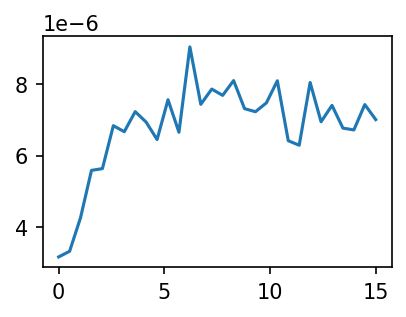

In [34]:
f = plt.figure(figsize=(3,2), dpi=150)
plt.plot(np.linspace(0, 15, 30), mae_test_vars)

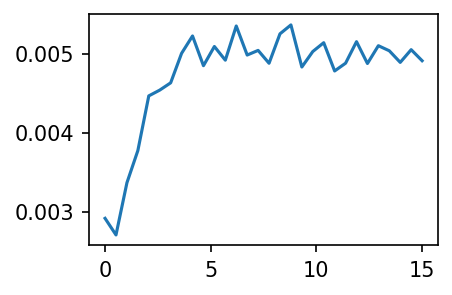

In [36]:
f = plt.figure(figsize=(3,2), dpi=150)
plt.plot(np.linspace(0, 15, 30), y_test_vars)

# ОБСУЖДЕНИЕ

### даже в идеализированном случае, при большом количестве данных и строгом соблюдении предпосылок LINE:

- При повышении дисбаланса между масштабами признаков неопределенность оценок меры качества сильно повышается
- При повышении дисбаланса между масштабами признаков неопределенность оценок целевой переменной сильно повышается

# ВЫВОДЫ

### - Необходимо приводить признаки к единому масштабу (нормировать)
### - Меру качества следует оценивать на отложенной (тестовой) выборке
### - Меру качества следует оценивать в подходе выборочной оценки мат.ожидания

# Нормирование признаков

## min-max нормирование

$$
\tilde{x} = \frac{x-\operatorname{min}\left(x\right)}{\operatorname{max}\left(x\right)-\operatorname{min}\left(x\right)}
$$

Text(0.5, 0, 'normed X values')

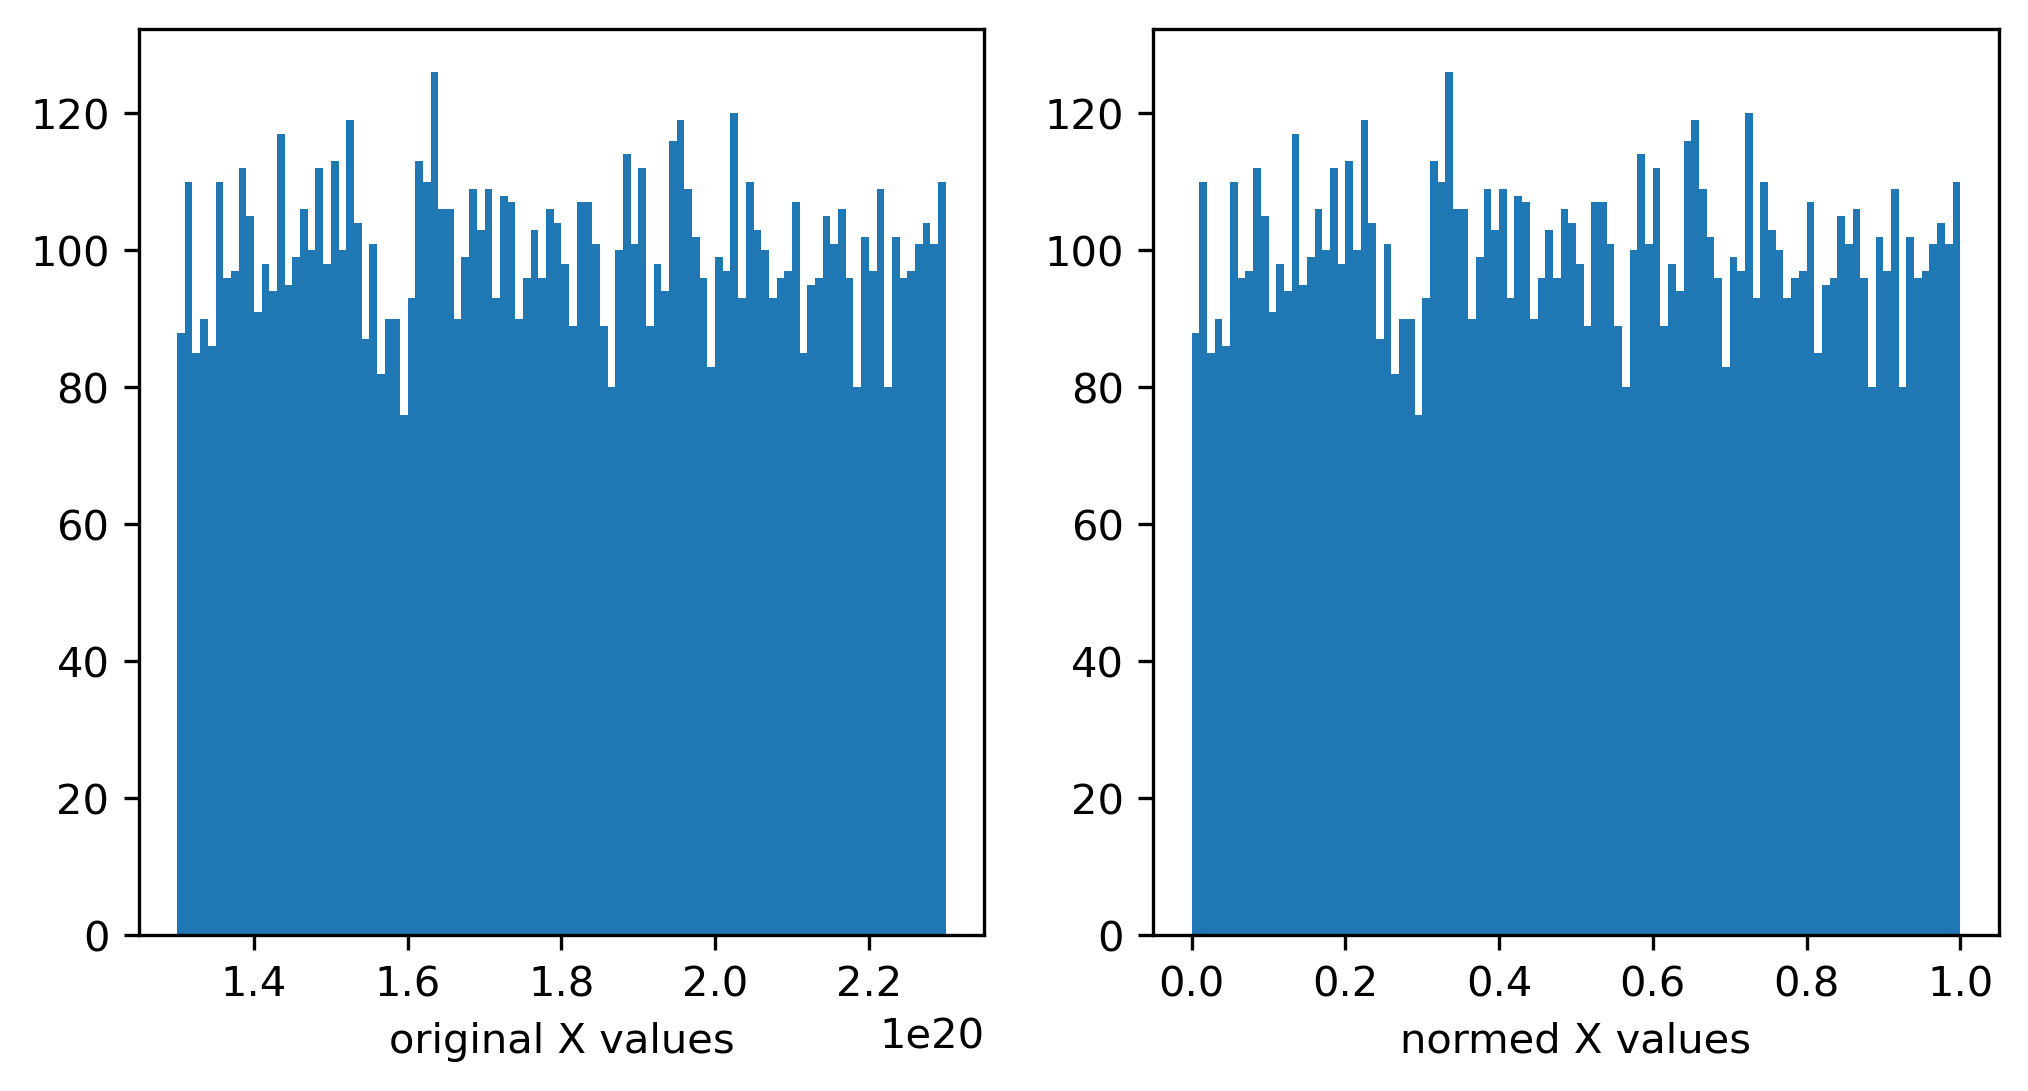

In [29]:
x = generate_data(10000, 1, 1e20)[0][:,1]+1.3e+20
x_ = (x-np.min(x))/(np.max(x)-np.min(x))

f = plt.figure(figsize=(8,4), dpi=300)
p1 = plt.subplot(1,2,1)
plt.hist(x, bins=100)
plt.xlabel('original X values')

p1 = plt.subplot(1,2,2)
plt.hist(x_, bins=100)
plt.xlabel('normed X values')

## p1-p99 нормирование

$$
\tilde{x} = \frac{x-\operatorname{Perc}\left(x, 1\%\right)}{\operatorname{Perc}\left(x, 99\%\right)-\operatorname{Perc}\left(x, 1\%\right)}
$$

Text(0.5, 0, 'normed X values')

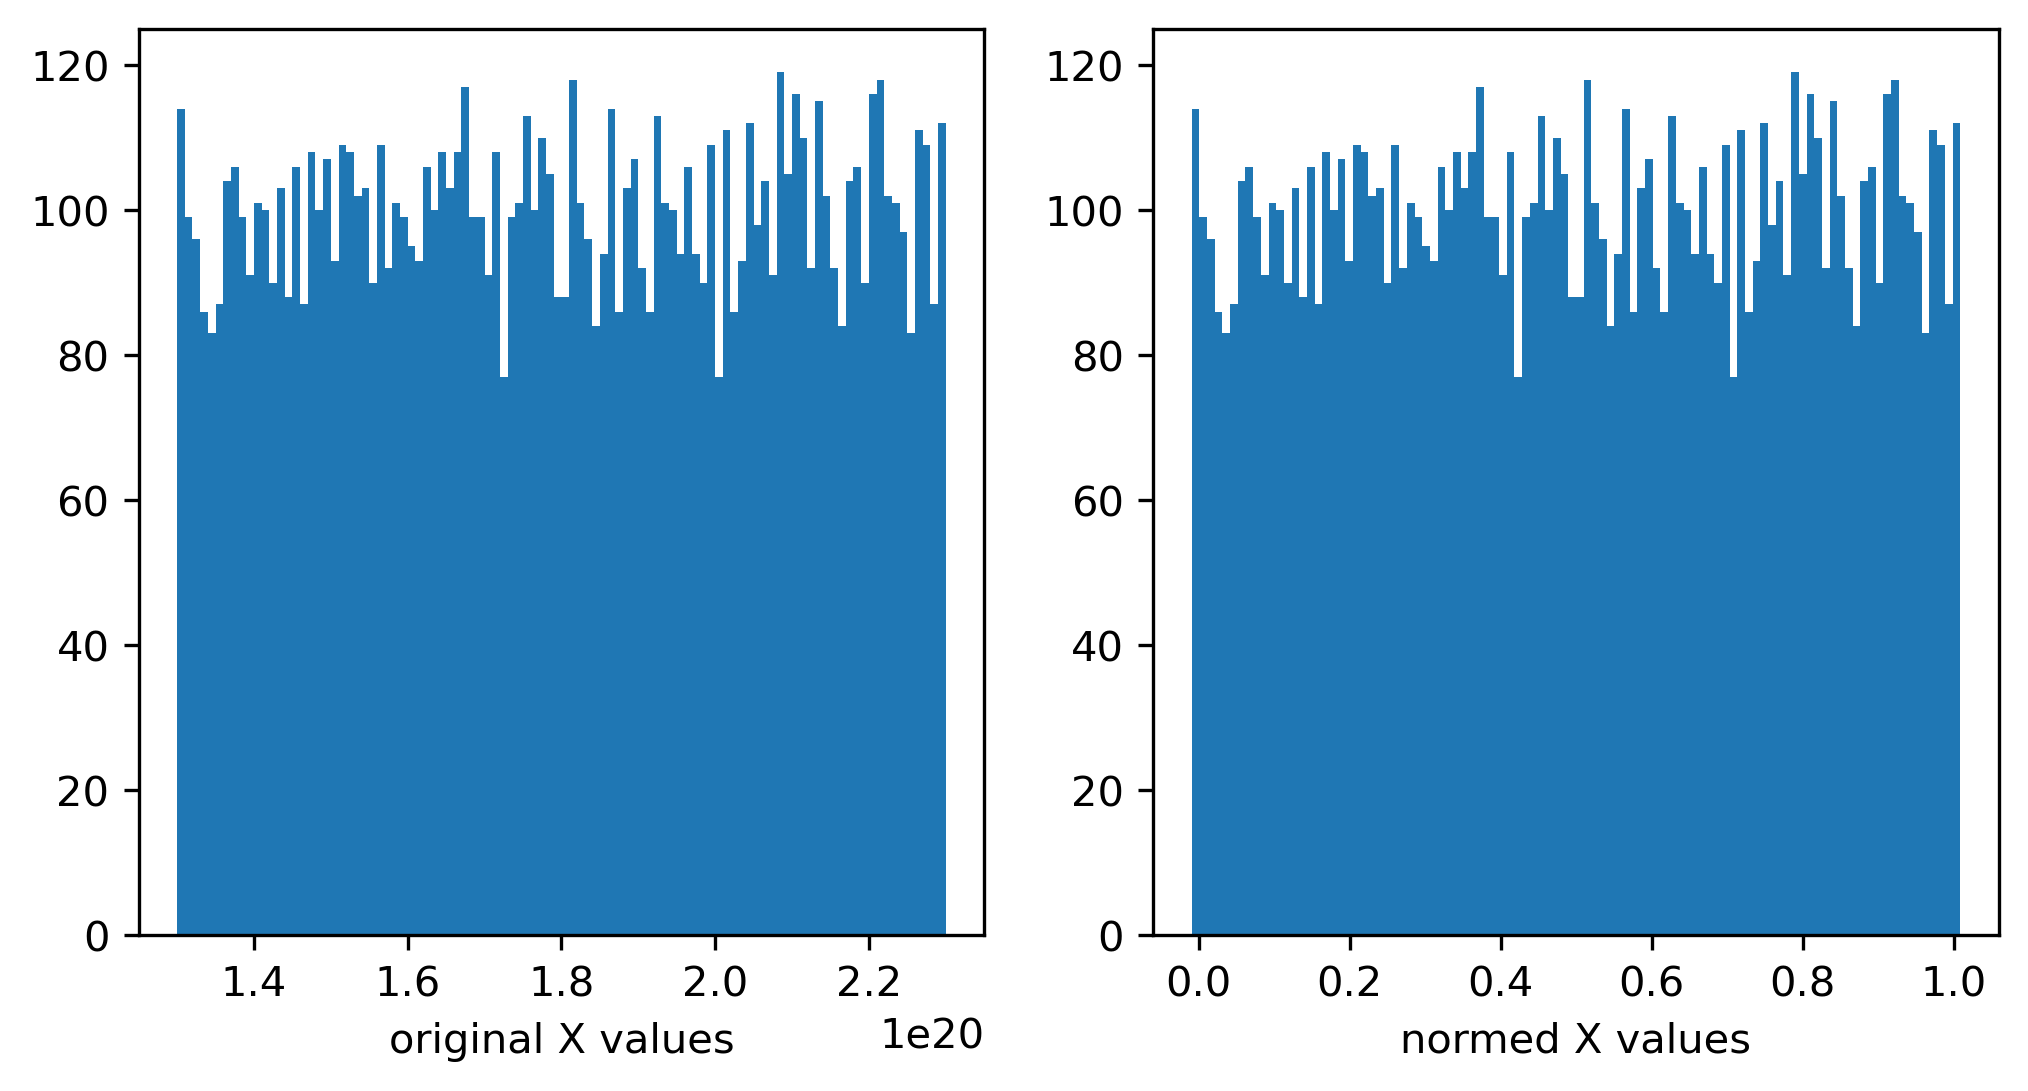

In [30]:
x = generate_data(10000, 1, 1e20)[0][:,1]+1.3e+20
x_ = (x-np.percentile(x, 1))/(np.percentile(x, 99)-np.percentile(x, 1))

f = plt.figure(figsize=(8,4), dpi=300)
p1 = plt.subplot(1,2,1)
plt.hist(x, bins=100)
plt.xlabel('original X values')

p1 = plt.subplot(1,2,2)
plt.hist(x_, bins=100)
plt.xlabel('normed X values')

## стандартизация

$$
\tilde{x} = \frac{x-\operatorname{mean}\left(x\right)}{\operatorname{Std}\left(x\right)}
$$

Text(0.5, 0, 'normed X values')

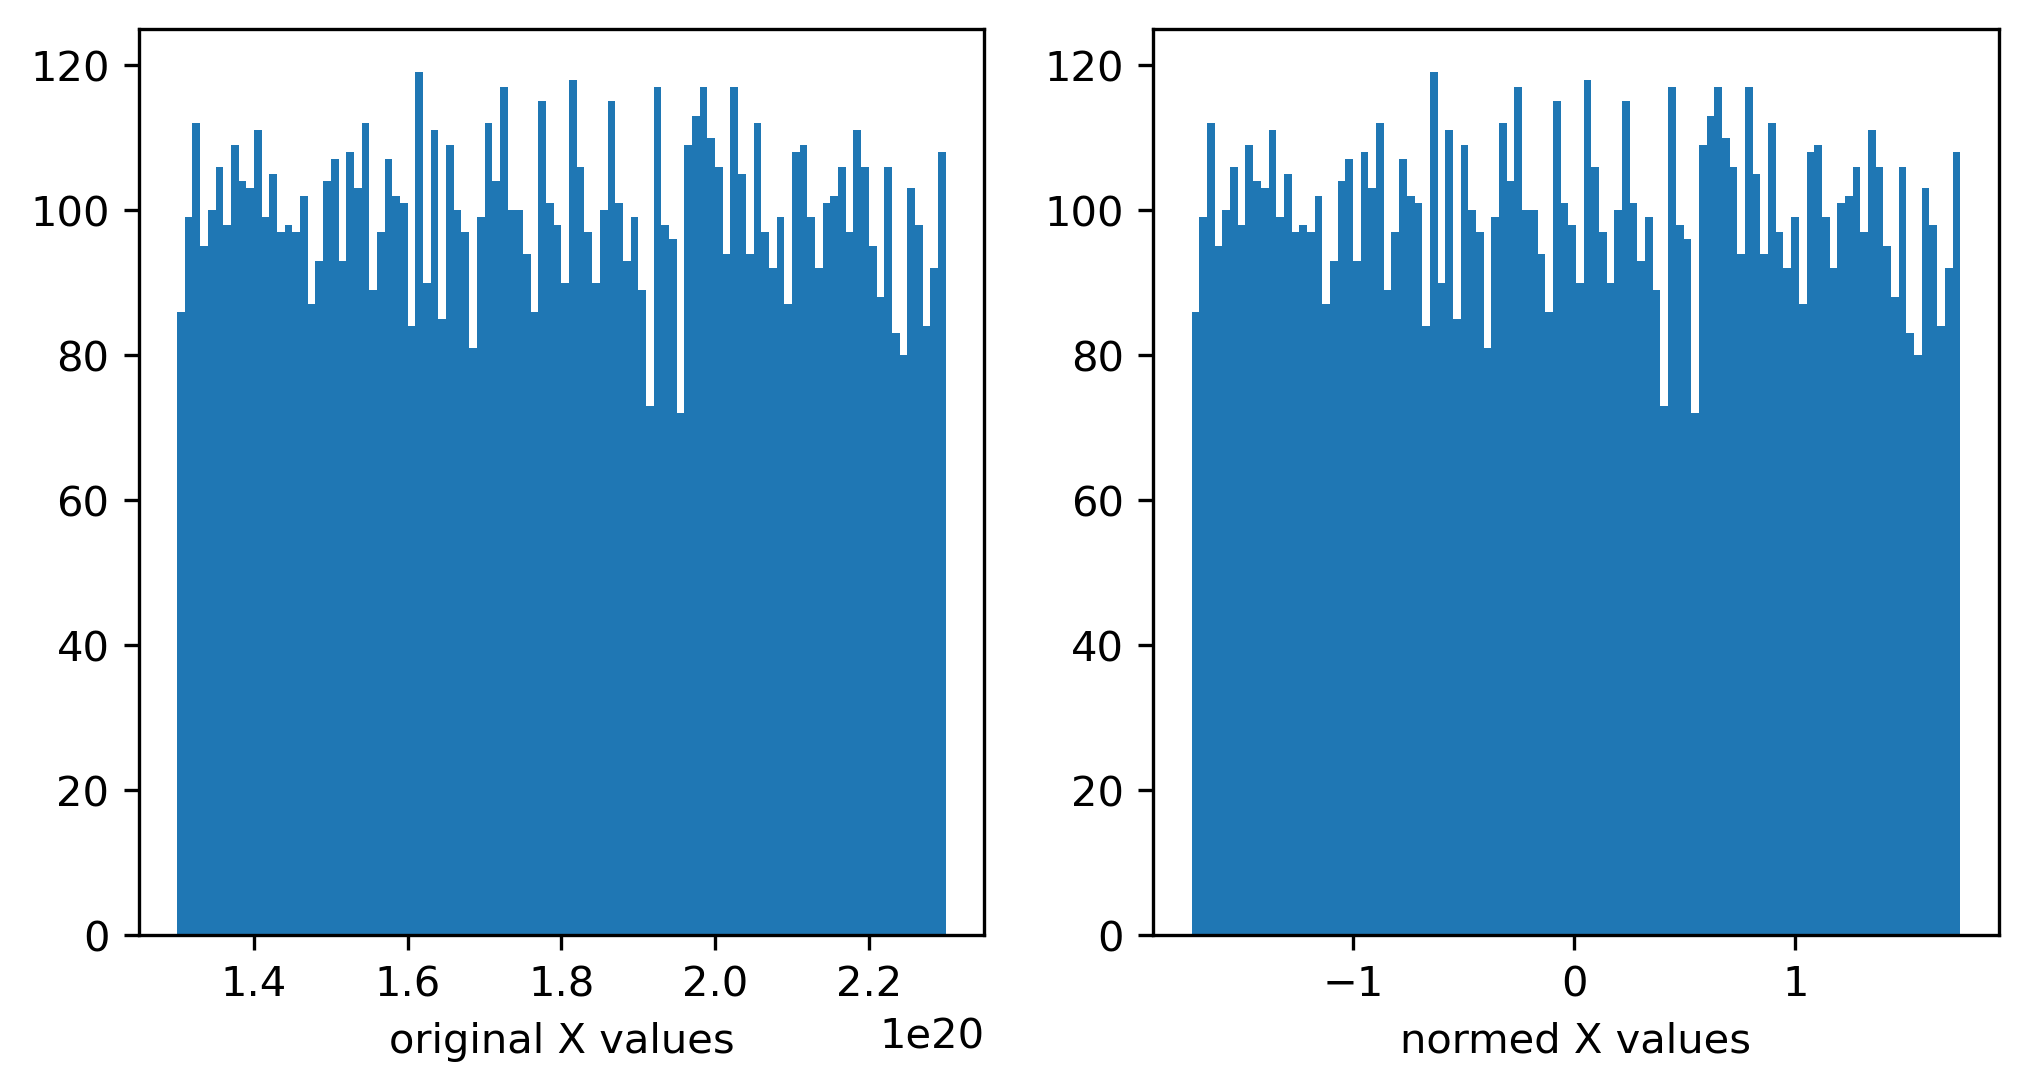

In [31]:
x = generate_data(10000, 1, 1e20)[0][:,1]+1.3e+20
x_ = (x-np.mean(x))/np.std(x)

f = plt.figure(figsize=(8,4), dpi=300)
p1 = plt.subplot(1,2,1)
plt.hist(x, bins=100)
plt.xlabel('original X values')

p1 = plt.subplot(1,2,2)
plt.hist(x_, bins=100)
plt.xlabel('normed X values')

In [35]:
print('Var(x_) = %f' % np.var(x_))

Var(x_) = 1.000000
